<a href="https://colab.research.google.com/github/konkuk-gaegul/3rd-Team-Project/blob/main/Pytorch_Corgi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웰시코기 학습
- 가장 성능이 좋은 경계선 감지 전처리를 적용한 set 4 to 7을 대표로 업로드
- set 4에서 Loss 0.5989, Accuracy : 89.23% 최고 성능을 기록

## 이미지 전처리 설명

set 1
- 선명화 처리

set 2
- 정방향(1 : 1)으로 자르기
- 대비향상 (YUV필터 적용)
- 선명화 처리

set 3
- 가우시안 블러 적용

set 4
- edge 추출 & 경계면 선명화 전처리 진행
- Sobel X (경계선 감지기)

set 5
- edge 추출 & 경계면 선명화 전처리 진행
- Sobel Y (경계선 감지기)

set 6
- edge 추출 & 경계면 선명화 전처리 진행
- Laplacian (경계선 감지기)

set 7
- edge 추출 & 경계면 선명화 전처리 진행
- Canny (경계선 감지기)

set 8
- 흑백처리 후, 선명화 처리

set 9
- 흑백처리 후, 가우시안 블러 적용

In [ ]:
%cd /home/안재형/saved_files/웰시코기

In [ ]:
# Loss_Accuracy에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

import copy
import os, shutil
import matplotlib as plt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
for i in range(4, 8):
    # set 9에서 j 번 째 학습을 의미
    for batch in range(7, 13):
        # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
        # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
        transforms_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
        ])

        transforms_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        data_dir = '/home/tutor/안재형/dog_pic/웰시코기'
        data_folder = os.path.join(data_dir, f'set_{i}')
        train_datasets = datasets.ImageFolder(os.path.join(data_folder, 'train'), transforms_train)
        test_datasets = datasets.ImageFolder(os.path.join(data_folder, 'test'), transforms_test)

        train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch, shuffle=True, num_workers=2)
        test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch, shuffle=True, num_workers=2)

        class_names = train_datasets.classes

        #--------------------------------------------#
        # 신경망 구성
        model = models.resnet34(pretrained=True)
        num_features = model.fc.in_features
        # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
        model.fc = nn.Linear(num_features, 2)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        #--------------------------------------------#
        print(f'-------------현재 set_{i} batch_size {batch}-------------')
        num_epochs = 50
        model.train()
        start_time = time.time()

        # 전체 반복(epoch) 수 만큼 반복하며
        for epoch in range(num_epochs):
            running_loss = 0.
            running_corrects = 0

            # 배치 단위로 학습 데이터 불러오기
            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 모델에 입력(forward)하고 결과 계산
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_datasets)
            epoch_acc = running_corrects / len(train_datasets) * 100.

            # 학습 과정 중에 결과 출력
            print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        #--------------------------------------------#

        model.eval()
        start_time = time.time()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
                print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')

            epoch_loss = running_loss / len(test_datasets)
            epoch_acc = running_corrects / len(test_datasets) * 100.
            print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

            Loss_Accuracy.append([i, batch, epoch_loss, epoch_acc])
            # corgi set i 학습 1인 경우를 의미
            torch.save(model, f'cor_set{i}_B{batch}_1.pth')
        
        # 모든 모델을 저장하지 않고 가장 좋은 성능의 모델을 저장
        if i == 4 and batch == 7:
            Best = [i, batch, epoch_loss, epoch_acc]

        elif epoch_loss < Best[2]:
            # Best 모델보다 Loss가 개선되면 저장
            Best = [i, batch, epoch_loss, epoch_acc]

        print(f'현재 Best는 set_{Best[0]} / batch : {Best[1]} / Loss : {Best[2]} / Acc : {Best[3]}')
    print()

-------------현재 set_4 batch_size 7-------------
#0 Loss: 0.5056 Acc: 76.8680% Time: 7.0139s
#1 Loss: 0.3994 Acc: 84.1351% Time: 13.9760s
#2 Loss: 0.3447 Acc: 86.2845% Time: 20.8617s
#3 Loss: 0.2406 Acc: 90.7881% Time: 27.7822s
#4 Loss: 0.1733 Acc: 93.0399% Time: 34.7048s
#5 Loss: 0.1577 Acc: 94.1658% Time: 41.6659s
#6 Loss: 0.1106 Acc: 96.4176% Time: 48.6080s
#7 Loss: 0.0748 Acc: 97.2364% Time: 55.5537s
#8 Loss: 0.0589 Acc: 97.6459% Time: 62.5168s
#9 Loss: 0.0825 Acc: 96.5200% Time: 69.4922s
#10 Loss: 0.1006 Acc: 96.7247% Time: 76.4715s
#11 Loss: 0.0943 Acc: 96.9294% Time: 83.4410s
#12 Loss: 0.0690 Acc: 98.0553% Time: 90.3922s
#13 Loss: 0.0358 Acc: 98.9765% Time: 97.3332s
#14 Loss: 0.1018 Acc: 97.5435% Time: 104.2505s
#15 Loss: 0.1012 Acc: 97.0317% Time: 111.1871s
#16 Loss: 0.0361 Acc: 98.7718% Time: 118.1494s
#17 Loss: 0.0394 Acc: 98.6694% Time: 125.0984s
#18 Loss: 0.0386 Acc: 98.6694% Time: 132.0306s
#19 Loss: 0.0193 Acc: 99.2835% Time: 138.9424s
#20 Loss: 0.0294 Acc: 99.0788% Time: 

#19 Loss: 0.0411 Acc: 98.2600% Time: 141.3375s
#20 Loss: 0.0499 Acc: 98.1576% Time: 148.4548s
#21 Loss: 0.0490 Acc: 98.3623% Time: 155.5329s
#22 Loss: 0.0167 Acc: 99.4882% Time: 162.6102s
#23 Loss: 0.0098 Acc: 99.7953% Time: 169.6900s
#24 Loss: 0.0079 Acc: 99.7953% Time: 176.7690s
#25 Loss: 0.0112 Acc: 99.4882% Time: 183.8912s
#26 Loss: 0.0162 Acc: 99.5906% Time: 190.9878s
#27 Loss: 0.0076 Acc: 99.8976% Time: 198.0705s
#28 Loss: 0.0055 Acc: 99.8976% Time: 205.1472s
#29 Loss: 0.0038 Acc: 99.8976% Time: 212.2619s
#30 Loss: 0.0132 Acc: 99.2835% Time: 219.3165s
#31 Loss: 0.0044 Acc: 100.0000% Time: 226.3782s
#32 Loss: 0.0122 Acc: 99.5906% Time: 233.4339s
#33 Loss: 0.0088 Acc: 99.7953% Time: 240.5088s
#34 Loss: 0.0077 Acc: 99.6929% Time: 247.5576s
#35 Loss: 0.0283 Acc: 99.2835% Time: 254.6547s
#36 Loss: 0.0201 Acc: 99.2835% Time: 261.6979s
#37 Loss: 0.0069 Acc: 99.8976% Time: 268.7580s
#38 Loss: 0.0070 Acc: 99.6929% Time: 275.8263s
#39 Loss: 0.0097 Acc: 99.5906% Time: 282.8852s
#40 Loss: 0.

#48 Loss: 0.0048 Acc: 99.8976% Time: 321.1183s
#49 Loss: 0.0061 Acc: 99.7953% Time: 327.6714s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.5989 Acc: 89.2308% Time: 0.8865s
현재 Best는 set_4 / batch : 11 / Loss : 0.5988848303664082 / Acc : 89.23076

#4 Loss: 0.1418 Acc: 95.0870% Time: 36.2724s
#5 Loss: 0.1057 Acc: 95.9058% Time: 43.6245s
#6 Loss: 0.0738 Acc: 97.6459% Time: 50.9976s
#7 Loss: 0.0861 Acc: 97.0317% Time: 58.3151s
#8 Loss: 0.0462 Acc: 98.8741% Time: 65.7144s
#9 Loss: 0.0587 Acc: 98.0553% Time: 73.0890s
#10 Loss: 0.0719 Acc: 97.9529% Time: 80.5275s
#11 Loss: 0.0517 Acc: 98.4647% Time: 87.9375s
#12 Loss: 0.0875 Acc: 96.6223% Time: 95.3232s
#13 Loss: 0.0231 Acc: 99.3859% Time: 102.7849s
#14 Loss: 0.0291 Acc: 99.0788% Time: 110.2661s
#15 Loss: 0.0359 Acc: 98.8741% Time: 117.6905s
#16 Loss: 0.0327 Acc: 98.7718% Time: 125.0819s
#17 Loss: 0.0538 Acc: 98.3623% Time: 132.5014s
#18 Loss: 0.0282 Acc: 99.0788% Time: 139.9161s
#19 Loss: 0.0710 Acc: 97.4411% Time: 147.3457s
#20 Loss: 0.0370 Acc: 98.9765% Time: 154.7757s
#21 Loss: 0.0437 Acc: 98.6694% Time: 162.2083s
#22 Loss: 0.0384 Acc: 98.4647% Time: 169.6344s
#23 Loss: 0.0196 Acc: 99.6929% Time: 177.0497s
#24 Loss: 0.0213 Acc: 99.3859% Time: 184.4366s
#25 Loss: 0.0244 Acc: 98.976

#29 Loss: 0.0061 Acc: 99.5906% Time: 198.2064s
#30 Loss: 0.0075 Acc: 99.5906% Time: 204.9835s
#31 Loss: 0.0062 Acc: 99.6929% Time: 211.7900s
#32 Loss: 0.0114 Acc: 99.5906% Time: 218.5911s
#33 Loss: 0.0217 Acc: 99.0788% Time: 225.4199s
#34 Loss: 0.0107 Acc: 99.5906% Time: 232.2373s
#35 Loss: 0.0171 Acc: 99.1812% Time: 239.1055s
#36 Loss: 0.0056 Acc: 99.7953% Time: 245.9720s
#37 Loss: 0.0070 Acc: 99.4882% Time: 252.8575s
#38 Loss: 0.0116 Acc: 99.2835% Time: 259.7030s
#39 Loss: 0.0325 Acc: 99.1812% Time: 266.5487s
#40 Loss: 0.0201 Acc: 99.0788% Time: 273.3744s
#41 Loss: 0.0130 Acc: 99.3859% Time: 280.2060s
#42 Loss: 0.0081 Acc: 99.7953% Time: 287.0576s
#43 Loss: 0.0072 Acc: 99.6929% Time: 293.8761s
#44 Loss: 0.0151 Acc: 99.2835% Time: 300.7171s
#45 Loss: 0.0364 Acc: 98.6694% Time: 307.5601s
#46 Loss: 0.0238 Acc: 99.1812% Time: 314.3925s
#47 Loss: 0.0112 Acc: 99.4882% Time: 321.2112s
#48 Loss: 0.0077 Acc: 99.5906% Time: 328.0343s
#49 Loss: 0.0139 Acc: 99.5906% Time: 334.8718s
[예측 결과: fat] 

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.9456 Acc: 84.6154% Time: 0.8577s
현재 Best는 set_4 / batch : 11 / Loss : 0.5988848303664082 / Acc : 89.23076629638672

-------------현재 set_6 batch_size 7-------------
#0 Loss: 0.4893 Acc: 77.1750% Time: 7.3807s
#1 Loss: 0.3684 Acc: 84.8516% Time: 14.7781s
#2 Loss: 0.3131 Acc: 86.2845% Time: 22.1543s
#3 Loss: 0.3017 Acc: 88.2293% Time: 29.5207s
#4 Loss: 0.2227 Acc: 90.8905% Time: 36.9026s
#5 Loss: 0.1661 Acc: 94.2682% Time: 44.2762s
#6 Loss: 0.1245 Acc: 94.8823% Time: 51.7011s
#7 Loss: 0.1776 Acc: 93.2446% Time: 59.1288s
#8 Loss: 0.1222 Acc: 95.9058% Time: 66.5201s
#9 Loss: 0.1328 Acc: 95.5988% Time: 73.9036s
#10 Loss: 0.1012 Acc: 96.2129% Time: 81.2651s
#11 Loss: 0.0735 Acc: 97.1341% Time: 88.6823s
#12 Loss: 0.0824 Acc: 97.1341% Time: 96.0750s
#13 Loss: 0.0562 Acc: 97.7482% Time: 103.4374s
#14 Loss: 0.0594 Acc: 97.4411% Time: 110.7884s
#15 Loss: 0.0542 Acc: 98.0553%

#14 Loss: 0.0815 Acc: 97.7482% Time: 100.1832s
#15 Loss: 0.0578 Acc: 98.4647% Time: 106.8159s
#16 Loss: 0.0431 Acc: 98.5670% Time: 113.4315s
#17 Loss: 0.0228 Acc: 99.2835% Time: 120.1380s
#18 Loss: 0.0357 Acc: 98.5670% Time: 126.8208s
#19 Loss: 0.0415 Acc: 98.6694% Time: 133.5370s
#20 Loss: 0.0179 Acc: 99.4882% Time: 140.1862s
#21 Loss: 0.0153 Acc: 99.2835% Time: 146.9222s
#22 Loss: 0.0167 Acc: 99.4882% Time: 153.5993s
#23 Loss: 0.0160 Acc: 99.3859% Time: 160.2836s
#24 Loss: 0.0119 Acc: 99.5906% Time: 167.0097s
#25 Loss: 0.0219 Acc: 99.2835% Time: 173.6798s
#26 Loss: 0.0284 Acc: 98.7718% Time: 180.3702s
#27 Loss: 0.0095 Acc: 99.4882% Time: 187.0831s
#28 Loss: 0.0248 Acc: 99.4882% Time: 193.7970s
#29 Loss: 0.0330 Acc: 98.6694% Time: 200.5205s
#30 Loss: 0.0228 Acc: 99.1812% Time: 207.2789s
#31 Loss: 0.0386 Acc: 98.5670% Time: 214.0280s
#32 Loss: 0.0125 Acc: 99.5906% Time: 220.7494s
#33 Loss: 0.0250 Acc: 99.1812% Time: 227.5146s
#34 Loss: 0.0178 Acc: 99.1812% Time: 234.2487s
#35 Loss: 0.0

#43 Loss: 0.0153 Acc: 99.2835% Time: 288.1790s
#44 Loss: 0.0060 Acc: 99.8976% Time: 294.6862s
#45 Loss: 0.0120 Acc: 99.5906% Time: 301.1847s
#46 Loss: 0.0096 Acc: 99.6929% Time: 307.7039s
#47 Loss: 0.0047 Acc: 99.7953% Time: 314.2123s
#48 Loss: 0.0121 Acc: 99.3859% Time: 320.7458s
#49 Loss: 0.0073 Acc: 99.7953% Time: 327.2759s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: 

-------------현재 set_7 batch_size 8-------------
#0 Loss: 0.5451 Acc: 74.4115% Time: 7.4561s
#1 Loss: 0.3630 Acc: 85.8751% Time: 14.8846s
#2 Loss: 0.2732 Acc: 89.0481% Time: 22.3425s
#3 Loss: 0.2105 Acc: 92.6305% Time: 29.7884s
#4 Loss: 0.2204 Acc: 90.7881% Time: 37.2429s
#5 Loss: 0.1336 Acc: 95.0870% Time: 44.6923s
#6 Loss: 0.1883 Acc: 92.8352% Time: 52.1675s
#7 Loss: 0.1567 Acc: 93.8587% Time: 59.6126s
#8 Loss: 0.1609 Acc: 94.8823% Time: 67.0297s
#9 Loss: 0.0951 Acc: 96.1105% Time: 74.4839s
#10 Loss: 0.1006 Acc: 96.3152% Time: 81.8868s
#11 Loss: 0.0554 Acc: 98.4647% Time: 89.3490s
#12 Loss: 0.1082 Acc: 96.6223% Time: 96.7961s
#13 Loss: 0.0650 Acc: 97.6459% Time: 104.2538s
#14 Loss: 0.0203 Acc: 99.3859% Time: 111.7433s
#15 Loss: 0.0435 Acc: 98.6694% Time: 119.2300s
#16 Loss: 0.0416 Acc: 98.5670% Time: 126.6755s
#17 Loss: 0.0253 Acc: 99.3859% Time: 134.0997s
#18 Loss: 0.0302 Acc: 99.1812% Time: 141.5209s
#19 Loss: 0.0355 Acc: 98.5670% Time: 148.9573s
#20 Loss: 0.0466 Acc: 98.2600% Time:

#24 Loss: 0.0130 Acc: 99.1812% Time: 162.6674s
#25 Loss: 0.0111 Acc: 99.4882% Time: 169.3417s
#26 Loss: 0.0086 Acc: 99.6929% Time: 175.9944s
#27 Loss: 0.0175 Acc: 99.1812% Time: 182.6480s
#28 Loss: 0.0107 Acc: 99.5906% Time: 189.3905s
#29 Loss: 0.0095 Acc: 99.3859% Time: 196.1074s
#30 Loss: 0.0073 Acc: 99.7953% Time: 202.8528s
#31 Loss: 0.0131 Acc: 99.3859% Time: 209.5843s
#32 Loss: 0.0134 Acc: 99.4882% Time: 216.3371s
#33 Loss: 0.0076 Acc: 99.5906% Time: 223.0823s
#34 Loss: 0.0088 Acc: 99.7953% Time: 229.8282s
#35 Loss: 0.0153 Acc: 99.1812% Time: 236.5996s
#36 Loss: 0.0212 Acc: 98.7718% Time: 243.3684s
#37 Loss: 0.0076 Acc: 99.7953% Time: 250.2155s
#38 Loss: 0.0087 Acc: 99.5906% Time: 257.0160s
#39 Loss: 0.0116 Acc: 99.3859% Time: 263.8085s
#40 Loss: 0.0065 Acc: 99.7953% Time: 270.6373s
#41 Loss: 0.0269 Acc: 99.0788% Time: 277.4557s
#42 Loss: 0.0110 Acc: 99.4882% Time: 284.3094s
#43 Loss: 0.0298 Acc: 98.5670% Time: 291.1342s
#44 Loss: 0.0126 Acc: 99.4882% Time: 297.9580s
#45 Loss: 0.0

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.7189 Acc: 84.3077% Time: 0.8305s
현재 Best는 set_4 / batch : 11 / Loss : 0.5988848303664082 / Acc : 89.23076629638672



In [ ]:
Loss_Accuracy

[[4, 7, 0.740768874121624, tensor(85.8462, device='cuda:0')],
 [4, 8, 0.6094482014729427, tensor(88.6154, device='cuda:0')],
 [4, 9, 0.6234226312900248, tensor(85.8462, device='cuda:0')],
 [4, 10, 0.6313748170872434, tensor(84.6154, device='cuda:0')],
 [4, 11, 0.5988848303664082, tensor(89.2308, device='cuda:0')],
 [4, 12, 0.6213499991342094, tensor(87.0769, device='cuda:0')],
 [5, 7, 1.0948172991933993, tensor(84.3077, device='cuda:0')],
 [5, 8, 0.9035174772945734, tensor(80.6154, device='cuda:0')],
 [5, 9, 1.2129374739053727, tensor(84.6154, device='cuda:0')],
 [5, 10, 0.9390777763838951, tensor(84.3077, device='cuda:0')],
 [5, 11, 1.0890440241602035, tensor(86.4615, device='cuda:0')],
 [5, 12, 0.9456473576081827, tensor(84.6154, device='cuda:0')],
 [6, 7, 0.8360337150190026, tensor(82.7692, device='cuda:0')],
 [6, 8, 0.646015105178723, tensor(84.3077, device='cuda:0')],
 [6, 9, 0.7165329688690746, tensor(84., device='cuda:0')],
 [6, 10, 0.6627338065488192, tensor(84.9231, device='cu

현재 Best는 set_4 / batch : 11 / Loss : 0.5988848303664082 / Acc : 89.23076629638672

In [ ]:
%cd /home/tutor/안재형/saved_files/웰시코기/set_4

/home/tutor/안재형/saved_files/웰시코기/set_4


In [ ]:
# Loss_Accuracy에 각 배치 사이즈마다의 성능을 넣어둔다
Loss_Accuracy = []

# 학습 2
- 학습 1에서 Best인 조건을 기준으로 한다
- epoch = range(50, 101, 10)
- 총 16번 반복해서 가장 좋은 조건을 찾는다.

In [ ]:
batchs = [8, 11]
i = 4
for batch in batchs:
# set 4에서 j 번 째 학습을 의미
    for j in range(1, 11):
        for epoch in range(50, 101, 10):
            # 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
            # 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 일부 변경
            transforms_train = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
            ])

            transforms_test = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            data_dir = '/home/tutor/안재형/dog_pic/웰시코기'
            data_folder = os.path.join(data_dir, f'set_{i}')
            train_datasets = datasets.ImageFolder(os.path.join(data_folder, 'train'), transforms_train)
            test_datasets = datasets.ImageFolder(os.path.join(data_folder, 'test'), transforms_test)

            train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch, shuffle=True, num_workers=2)
            test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch, shuffle=True, num_workers=2)

    #         print('학습 데이터셋 크기:', len(train_datasets))
    #         print('테스트 데이터셋 크기:', len(test_datasets))

            class_names = train_datasets.classes
    #         print('클래스:', class_names)

            #--------------------------------------------#

            model = models.resnet34(pretrained=True)
            num_features = model.fc.in_features
            # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 2개로 교체하여 마지막 레이어 다시 학습
            model.fc = nn.Linear(num_features, 2)
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

            #--------------------------------------------#
            print(f'-------------현재 set_{i} batch_size {batch} iteration {j} epoch {epoch}-------------')
            num_epochs = epoch
            model.train()
            start_time = time.time()

            # 전체 반복(epoch) 수 만큼 반복하며
            for epoch in range(num_epochs):
                running_loss = 0.
                running_corrects = 0

                # 배치 단위로 학습 데이터 불러오기
                for inputs, labels in train_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 모델에 입력(forward)하고 결과 계산
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(train_datasets)
                epoch_acc = running_corrects / len(train_datasets) * 100.

                # 학습 과정 중에 결과 출력
                print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

            #--------------------------------------------#

            model.eval()
            start_time = time.time()

            with torch.no_grad():
                running_loss = 0.
                running_corrects = 0

                for inputs, labels in test_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
                    print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        #             imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

                epoch_loss = running_loss / len(test_datasets)
                epoch_acc = running_corrects / len(test_datasets) * 100.
                print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

                Loss_Accuracy.append([i, batch, epoch, epoch_loss, epoch_acc])
                # corgi set i 학습 1인 경우를 의미
                torch.save(model, f'cor_set{i}_B{batch}_E{epoch}_2.pth')

            # 모든 모델을 저장하지 않고 가장 좋은 성능의 모델을 저장
            if batch == 8 and j == 1 and epoch == 50:
                Best = [i, batch, j, epoch, epoch_loss, epoch_acc]

            elif epoch_loss < Best[4]:
                # Best 모델보다 Loss가 개선되면 저장
                Best = [i, batch, j, epoch, epoch_loss, epoch_acc]

            print(f'현재 Best는 set_{Best[0]} / batch : {Best[1]} / iteration : {Best[2]} / batch : {Best[3]} / Loss : {Best[4]} / Acc : {Best[5]}')
        print()

-------------현재 set_4 batch_size 8 iteration 1 epoch 50-------------
#0 Loss: 0.5106 Acc: 77.0727% Time: 7.1362s
#1 Loss: 0.3568 Acc: 85.6704% Time: 14.2127s
#2 Loss: 0.3048 Acc: 87.4104% Time: 21.2949s
#3 Loss: 0.1694 Acc: 93.4493% Time: 28.4209s
#4 Loss: 0.1552 Acc: 93.9611% Time: 35.5231s
#5 Loss: 0.1416 Acc: 95.0870% Time: 42.6618s
#6 Loss: 0.0531 Acc: 98.2600% Time: 49.8248s
#7 Loss: 0.1531 Acc: 94.5752% Time: 56.9934s
#8 Loss: 0.0750 Acc: 96.8270% Time: 64.1910s
#9 Loss: 0.0793 Acc: 97.5435% Time: 71.4326s
#10 Loss: 0.0502 Acc: 98.4647% Time: 78.7510s
#11 Loss: 0.0821 Acc: 97.4411% Time: 86.0286s
#12 Loss: 0.0681 Acc: 97.5435% Time: 93.3709s
#13 Loss: 0.0377 Acc: 98.8741% Time: 100.7330s
#14 Loss: 0.0437 Acc: 98.7718% Time: 108.0752s
#15 Loss: 0.0621 Acc: 98.0553% Time: 115.4416s
#16 Loss: 0.0515 Acc: 98.0553% Time: 122.8530s
#17 Loss: 0.0477 Acc: 98.2600% Time: 130.2436s
#18 Loss: 0.0263 Acc: 99.0788% Time: 137.6492s
#19 Loss: 0.0278 Acc: 99.4882% Time: 145.0744s
#20 Loss: 0.030

#9 Loss: 0.0798 Acc: 97.0317% Time: 69.7244s
#10 Loss: 0.1100 Acc: 96.0082% Time: 76.6563s
#11 Loss: 0.0401 Acc: 99.0788% Time: 83.6450s
#12 Loss: 0.0375 Acc: 98.9765% Time: 90.5949s
#13 Loss: 0.0503 Acc: 98.4647% Time: 97.5436s
#14 Loss: 0.0506 Acc: 98.0553% Time: 104.5249s
#15 Loss: 0.0657 Acc: 97.7482% Time: 111.4689s
#16 Loss: 0.0317 Acc: 99.0788% Time: 118.4079s
#17 Loss: 0.0452 Acc: 98.6694% Time: 125.3565s
#18 Loss: 0.0193 Acc: 99.1812% Time: 132.3506s
#19 Loss: 0.0301 Acc: 99.2835% Time: 139.3193s
#20 Loss: 0.0230 Acc: 99.4882% Time: 146.2994s
#21 Loss: 0.0332 Acc: 99.0788% Time: 153.2604s
#22 Loss: 0.0396 Acc: 98.8741% Time: 160.2334s
#23 Loss: 0.0224 Acc: 99.3859% Time: 167.2278s
#24 Loss: 0.0438 Acc: 98.2600% Time: 174.2121s
#25 Loss: 0.0287 Acc: 98.8741% Time: 181.2175s
#26 Loss: 0.0152 Acc: 99.4882% Time: 188.2015s
#27 Loss: 0.0079 Acc: 99.7953% Time: 195.1751s
#28 Loss: 0.0068 Acc: 99.8976% Time: 202.1304s
#29 Loss: 0.0287 Acc: 99.2835% Time: 209.0830s
#30 Loss: 0.0251 Ac

[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.6571 Acc: 86.1538% Time: 0.9801s
현재 Best는 set_4 / batch : 8 / iteration : 1 / batch : 49 / Loss : 0.5647587989083304 / Acc : 87.07691955566406
-------------현재 set_4 batch_size 8 iteration 1 epoch 90-------------
#0 Loss: 0.5024 Acc: 78.3009% Time: 7.4614s
#1 Loss: 0.3655 Acc: 

#38 Loss: 0.0108 Acc: 99.6929% Time: 289.1016s
#39 Loss: 0.0062 Acc: 99.7953% Time: 296.5330s
#40 Loss: 0.0076 Acc: 99.6929% Time: 303.8957s
#41 Loss: 0.0248 Acc: 99.2835% Time: 311.2390s
#42 Loss: 0.0275 Acc: 99.1812% Time: 318.6138s
#43 Loss: 0.0234 Acc: 99.2835% Time: 325.9364s
#44 Loss: 0.0070 Acc: 99.7953% Time: 333.2305s
#45 Loss: 0.0099 Acc: 99.7953% Time: 340.5396s
#46 Loss: 0.0280 Acc: 99.0788% Time: 347.8694s
#47 Loss: 0.0359 Acc: 98.7718% Time: 355.1792s
#48 Loss: 0.0216 Acc: 99.0788% Time: 362.5358s
#49 Loss: 0.0112 Acc: 99.4882% Time: 369.9259s
#50 Loss: 0.0172 Acc: 99.3859% Time: 377.2978s
#51 Loss: 0.0069 Acc: 99.6929% Time: 384.7107s
#52 Loss: 0.0055 Acc: 100.0000% Time: 392.1903s
#53 Loss: 0.0040 Acc: 99.8976% Time: 399.6263s
#54 Loss: 0.0206 Acc: 99.0788% Time: 407.0425s
#55 Loss: 0.0135 Acc: 99.6929% Time: 414.4767s
#56 Loss: 0.0152 Acc: 99.4882% Time: 421.8893s
#57 Loss: 0.0232 Acc: 99.4882% Time: 429.3202s
#58 Loss: 0.0287 Acc: 98.9765% Time: 436.7317s
#59 Loss: 0.

#8 Loss: 0.0606 Acc: 97.9529% Time: 62.9744s
#9 Loss: 0.1104 Acc: 96.3152% Time: 70.0557s
#10 Loss: 0.0878 Acc: 97.3388% Time: 77.1050s
#11 Loss: 0.0761 Acc: 97.3388% Time: 84.1737s
#12 Loss: 0.0592 Acc: 97.6459% Time: 91.2317s
#13 Loss: 0.0458 Acc: 98.0553% Time: 98.3229s
#14 Loss: 0.0398 Acc: 98.3623% Time: 105.3828s
#15 Loss: 0.0311 Acc: 98.8741% Time: 112.4536s
#16 Loss: 0.0418 Acc: 98.4647% Time: 119.5362s
#17 Loss: 0.0495 Acc: 98.5670% Time: 126.6496s
#18 Loss: 0.0494 Acc: 98.0553% Time: 133.8252s
#19 Loss: 0.0642 Acc: 97.5435% Time: 140.9826s
#20 Loss: 0.0309 Acc: 98.7718% Time: 148.1801s
#21 Loss: 0.0434 Acc: 98.3623% Time: 155.4153s
#22 Loss: 0.0259 Acc: 98.9765% Time: 162.6502s
#23 Loss: 0.0420 Acc: 98.4647% Time: 169.9017s
#24 Loss: 0.0226 Acc: 99.1812% Time: 177.1677s
#25 Loss: 0.0167 Acc: 99.1812% Time: 184.4757s
#26 Loss: 0.0242 Acc: 99.4882% Time: 191.7668s
#27 Loss: 0.0183 Acc: 99.2835% Time: 199.0560s
#28 Loss: 0.0144 Acc: 99.3859% Time: 206.4078s
#29 Loss: 0.0110 Acc:

-------------현재 set_4 batch_size 8 iteration 2 epoch 80-------------
#0 Loss: 0.5212 Acc: 76.8680% Time: 7.3432s
#1 Loss: 0.3212 Acc: 86.3869% Time: 14.7113s
#2 Loss: 0.2484 Acc: 90.7881% Time: 22.0549s
#3 Loss: 0.1768 Acc: 94.0635% Time: 29.4336s
#4 Loss: 0.1253 Acc: 95.5988% Time: 36.8046s
#5 Loss: 0.1165 Acc: 95.7011% Time: 44.1676s
#6 Loss: 0.1022 Acc: 96.9294% Time: 51.4921s
#7 Loss: 0.1201 Acc: 96.5200% Time: 58.8463s
#8 Loss: 0.0846 Acc: 97.1341% Time: 66.2197s
#9 Loss: 0.0746 Acc: 97.5435% Time: 73.5615s
#10 Loss: 0.0945 Acc: 96.9294% Time: 80.9016s
#11 Loss: 0.0584 Acc: 98.0553% Time: 88.2419s
#12 Loss: 0.0613 Acc: 97.4411% Time: 95.5803s
#13 Loss: 0.0846 Acc: 96.9294% Time: 102.9512s
#14 Loss: 0.0373 Acc: 98.7718% Time: 110.3146s
#15 Loss: 0.0191 Acc: 99.5906% Time: 117.6502s
#16 Loss: 0.0304 Acc: 99.2835% Time: 125.0116s
#17 Loss: 0.0465 Acc: 98.4647% Time: 132.3489s
#18 Loss: 0.0394 Acc: 98.7718% Time: 139.7031s
#19 Loss: 0.0408 Acc: 98.9765% Time: 147.0400s
#20 Loss: 0.060

#67 Loss: 0.0035 Acc: 99.8976% Time: 502.5150s
#68 Loss: 0.0127 Acc: 99.4882% Time: 509.8833s
#69 Loss: 0.0195 Acc: 99.2835% Time: 517.2547s
#70 Loss: 0.0100 Acc: 99.5906% Time: 524.6394s
#71 Loss: 0.0032 Acc: 99.8976% Time: 532.0220s
#72 Loss: 0.0068 Acc: 99.6929% Time: 539.3776s
#73 Loss: 0.0073 Acc: 99.6929% Time: 546.7096s
#74 Loss: 0.0119 Acc: 99.4882% Time: 554.0868s
#75 Loss: 0.0198 Acc: 98.9765% Time: 561.5116s
#76 Loss: 0.0172 Acc: 99.4882% Time: 568.9075s
#77 Loss: 0.0089 Acc: 99.6929% Time: 576.2502s
#78 Loss: 0.0052 Acc: 99.7953% Time: 583.6538s
#79 Loss: 0.0016 Acc: 100.0000% Time: 591.0326s
#80 Loss: 0.0016 Acc: 100.0000% Time: 598.3805s
#81 Loss: 0.0049 Acc: 99.6929% Time: 605.7452s
#82 Loss: 0.0076 Acc: 99.6929% Time: 613.1058s
#83 Loss: 0.0094 Acc: 99.6929% Time: 620.4866s
#84 Loss: 0.0024 Acc: 99.8976% Time: 627.8809s
#85 Loss: 0.0037 Acc: 99.7953% Time: 635.2401s
#86 Loss: 0.0076 Acc: 99.7953% Time: 642.6377s
#87 Loss: 0.0064 Acc: 99.7953% Time: 650.0355s
#88 Loss: 0

-------------현재 set_4 batch_size 8 iteration 3 epoch 50-------------
#0 Loss: 0.5235 Acc: 77.3797% Time: 7.3691s
#1 Loss: 0.3303 Acc: 86.2845% Time: 14.7500s
#2 Loss: 0.2439 Acc: 90.0716% Time: 22.1348s
#3 Loss: 0.1568 Acc: 93.5517% Time: 29.5109s
#4 Loss: 0.1545 Acc: 94.1658% Time: 36.8797s
#5 Loss: 0.1607 Acc: 93.8587% Time: 44.2414s
#6 Loss: 0.1077 Acc: 96.2129% Time: 51.6347s
#7 Loss: 0.0955 Acc: 96.4176% Time: 59.0114s
#8 Loss: 0.0731 Acc: 97.6459% Time: 66.3926s
#9 Loss: 0.0782 Acc: 96.5200% Time: 73.7875s
#10 Loss: 0.0768 Acc: 97.2364% Time: 81.1809s
#11 Loss: 0.0489 Acc: 98.1576% Time: 88.5621s
#12 Loss: 0.0342 Acc: 98.9765% Time: 95.9532s
#13 Loss: 0.0299 Acc: 98.9765% Time: 103.2992s
#14 Loss: 0.0362 Acc: 98.3623% Time: 110.7064s
#15 Loss: 0.0466 Acc: 98.6694% Time: 118.0792s
#16 Loss: 0.0384 Acc: 98.8741% Time: 125.4572s
#17 Loss: 0.0196 Acc: 99.2835% Time: 132.8481s
#18 Loss: 0.0365 Acc: 98.8741% Time: 140.2131s
#19 Loss: 0.0313 Acc: 98.7718% Time: 147.5665s
#20 Loss: 0.058

#9 Loss: 0.0659 Acc: 98.0553% Time: 72.2488s
#10 Loss: 0.0488 Acc: 98.2600% Time: 79.5588s
#11 Loss: 0.0526 Acc: 98.1576% Time: 86.9053s
#12 Loss: 0.0764 Acc: 97.1341% Time: 94.2456s
#13 Loss: 0.0796 Acc: 97.3388% Time: 101.6329s
#14 Loss: 0.0879 Acc: 97.3388% Time: 108.9969s
#15 Loss: 0.0512 Acc: 98.1576% Time: 116.2734s
#16 Loss: 0.0444 Acc: 98.7718% Time: 123.4702s
#17 Loss: 0.0597 Acc: 97.7482% Time: 130.5814s
#18 Loss: 0.0622 Acc: 97.5435% Time: 137.6620s
#19 Loss: 0.0414 Acc: 99.0788% Time: 144.6855s
#20 Loss: 0.0306 Acc: 99.2835% Time: 151.7076s
#21 Loss: 0.0335 Acc: 98.6694% Time: 158.7146s
#22 Loss: 0.0424 Acc: 98.7718% Time: 165.7147s
#23 Loss: 0.0364 Acc: 98.7718% Time: 172.6701s
#24 Loss: 0.0273 Acc: 98.9765% Time: 179.6308s
#25 Loss: 0.0178 Acc: 99.4882% Time: 186.6312s
#26 Loss: 0.0322 Acc: 98.8741% Time: 193.6127s
#27 Loss: 0.0099 Acc: 99.6929% Time: 200.5627s
#28 Loss: 0.0082 Acc: 99.7953% Time: 207.5196s
#29 Loss: 0.0237 Acc: 99.1812% Time: 214.4985s
#30 Loss: 0.0442 A

[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[Test Phase] Loss: 0.6784 Acc: 84.3077% Time: 0.9703s
현재 Best는 set_4 / batch : 8 / iteration : 3 / batch : 49 / Loss : 0.5598587300528575 / Acc : 86.15384674072266
-------------현재 set_4 batch_size 8 iteration 3 epoch 90-------------
#0 Loss: 0.5426 Acc: 76.5609% Time: 7.1999s
#1 Loss: 0.3504 Acc: 

#38 Loss: 0.0104 Acc: 99.6929% Time: 280.6920s
#39 Loss: 0.0111 Acc: 99.7953% Time: 287.6476s
#40 Loss: 0.0072 Acc: 99.7953% Time: 294.6114s
#41 Loss: 0.0201 Acc: 99.1812% Time: 301.5673s
#42 Loss: 0.0299 Acc: 98.7718% Time: 308.5655s
#43 Loss: 0.0074 Acc: 99.7953% Time: 315.5447s
#44 Loss: 0.0093 Acc: 99.7953% Time: 322.5147s
#45 Loss: 0.0301 Acc: 99.3859% Time: 329.4804s
#46 Loss: 0.0441 Acc: 98.5670% Time: 336.4419s
#47 Loss: 0.0109 Acc: 99.5906% Time: 343.4303s
#48 Loss: 0.0263 Acc: 99.1812% Time: 350.4011s
#49 Loss: 0.0112 Acc: 99.7953% Time: 357.3960s
#50 Loss: 0.0063 Acc: 99.8976% Time: 364.4198s
#51 Loss: 0.0124 Acc: 99.8976% Time: 371.4166s
#52 Loss: 0.0340 Acc: 99.0788% Time: 378.4589s
#53 Loss: 0.0152 Acc: 99.3859% Time: 385.4789s
#54 Loss: 0.0155 Acc: 99.5906% Time: 392.4980s
#55 Loss: 0.0152 Acc: 99.5906% Time: 399.5604s
#56 Loss: 0.0203 Acc: 99.3859% Time: 406.6161s
#57 Loss: 0.0187 Acc: 99.3859% Time: 413.7196s
#58 Loss: 0.0295 Acc: 99.2835% Time: 420.7850s
#59 Loss: 0.0

#8 Loss: 0.0801 Acc: 97.2364% Time: 66.7014s
#9 Loss: 0.0588 Acc: 97.5435% Time: 74.0859s
#10 Loss: 0.0658 Acc: 97.8506% Time: 81.4422s
#11 Loss: 0.0596 Acc: 97.5435% Time: 88.8450s
#12 Loss: 0.0426 Acc: 98.1576% Time: 96.2369s
#13 Loss: 0.0376 Acc: 98.4647% Time: 103.5920s
#14 Loss: 0.0631 Acc: 98.0553% Time: 110.9606s
#15 Loss: 0.0762 Acc: 97.6459% Time: 118.3312s
#16 Loss: 0.0358 Acc: 99.2835% Time: 125.6966s
#17 Loss: 0.0273 Acc: 98.5670% Time: 133.0754s
#18 Loss: 0.0241 Acc: 98.9765% Time: 140.4861s
#19 Loss: 0.0340 Acc: 99.0788% Time: 147.8835s
#20 Loss: 0.0652 Acc: 97.9529% Time: 155.3112s
#21 Loss: 0.0302 Acc: 98.7718% Time: 162.7560s
#22 Loss: 0.0253 Acc: 98.8741% Time: 170.2170s
#23 Loss: 0.0108 Acc: 99.7953% Time: 177.6518s
#24 Loss: 0.0115 Acc: 99.8976% Time: 185.0667s
#25 Loss: 0.0134 Acc: 99.7953% Time: 192.5080s
#26 Loss: 0.0436 Acc: 98.7718% Time: 199.8890s
#27 Loss: 0.0484 Acc: 98.3623% Time: 207.2556s
#28 Loss: 0.0126 Acc: 99.5906% Time: 214.6059s
#29 Loss: 0.0112 Acc

-------------현재 set_4 batch_size 8 iteration 4 epoch 80-------------
#0 Loss: 0.5055 Acc: 77.8915% Time: 7.1229s
#1 Loss: 0.3429 Acc: 84.4422% Time: 14.2186s
#2 Loss: 0.2253 Acc: 90.9928% Time: 21.3691s
#3 Loss: 0.2218 Acc: 91.2999% Time: 28.5003s
#4 Loss: 0.1395 Acc: 94.8823% Time: 35.6455s
#5 Loss: 0.1153 Acc: 95.9058% Time: 42.8610s
#6 Loss: 0.1405 Acc: 94.4729% Time: 50.0978s
#7 Loss: 0.1004 Acc: 96.1105% Time: 57.3299s
#8 Loss: 0.1147 Acc: 95.8035% Time: 64.5926s
#9 Loss: 0.0884 Acc: 96.5200% Time: 71.8972s
#10 Loss: 0.0570 Acc: 98.2600% Time: 79.2076s
#11 Loss: 0.0592 Acc: 98.2600% Time: 86.4881s
#12 Loss: 0.0611 Acc: 97.7482% Time: 93.7885s
#13 Loss: 0.0392 Acc: 98.8741% Time: 101.0913s
#14 Loss: 0.0179 Acc: 99.4882% Time: 108.4175s
#15 Loss: 0.0229 Acc: 98.9765% Time: 115.8174s
#16 Loss: 0.0393 Acc: 98.6694% Time: 123.1854s
#17 Loss: 0.0548 Acc: 97.7482% Time: 130.5606s
#18 Loss: 0.0464 Acc: 98.1576% Time: 137.9261s
#19 Loss: 0.0233 Acc: 99.3859% Time: 145.3241s
#20 Loss: 0.038

#67 Loss: 0.0030 Acc: 99.8976% Time: 488.9004s
#68 Loss: 0.0138 Acc: 99.3859% Time: 496.3324s
#69 Loss: 0.0045 Acc: 99.7953% Time: 503.7646s
#70 Loss: 0.0112 Acc: 99.5906% Time: 511.1402s
#71 Loss: 0.0036 Acc: 99.7953% Time: 518.5637s
#72 Loss: 0.0277 Acc: 99.2835% Time: 525.9631s
#73 Loss: 0.0249 Acc: 99.1812% Time: 533.3226s
#74 Loss: 0.0175 Acc: 99.3859% Time: 540.7304s
#75 Loss: 0.0162 Acc: 99.4882% Time: 548.0916s
#76 Loss: 0.0068 Acc: 99.6929% Time: 555.4648s
#77 Loss: 0.0032 Acc: 100.0000% Time: 562.8441s
#78 Loss: 0.0031 Acc: 99.8976% Time: 570.2275s
#79 Loss: 0.0058 Acc: 99.7953% Time: 577.5870s
#80 Loss: 0.0063 Acc: 99.7953% Time: 584.9050s
#81 Loss: 0.0062 Acc: 99.8976% Time: 592.2510s
#82 Loss: 0.0293 Acc: 99.3859% Time: 599.5791s
#83 Loss: 0.0117 Acc: 99.6929% Time: 606.9091s
#84 Loss: 0.0046 Acc: 99.8976% Time: 614.2781s
#85 Loss: 0.0030 Acc: 100.0000% Time: 621.6471s
#86 Loss: 0.0021 Acc: 99.8976% Time: 628.9935s
#87 Loss: 0.0033 Acc: 99.7953% Time: 636.3875s
#88 Loss: 0

-------------현재 set_4 batch_size 8 iteration 5 epoch 50-------------
#0 Loss: 0.5219 Acc: 77.5844% Time: 7.4172s
#1 Loss: 0.3287 Acc: 85.0563% Time: 14.8361s
#2 Loss: 0.2543 Acc: 89.7646% Time: 22.2398s
#3 Loss: 0.2041 Acc: 92.4258% Time: 29.6586s
#4 Loss: 0.1830 Acc: 92.7328% Time: 37.0545s
#5 Loss: 0.1189 Acc: 95.1894% Time: 44.4915s
#6 Loss: 0.1045 Acc: 95.9058% Time: 51.9119s
#7 Loss: 0.0700 Acc: 97.5435% Time: 59.3160s
#8 Loss: 0.0728 Acc: 97.3388% Time: 66.6883s
#9 Loss: 0.0704 Acc: 97.6459% Time: 74.1375s
#10 Loss: 0.0800 Acc: 97.2364% Time: 81.5511s
#11 Loss: 0.0653 Acc: 97.7482% Time: 88.9638s
#12 Loss: 0.0463 Acc: 98.3623% Time: 96.3545s
#13 Loss: 0.0206 Acc: 99.3859% Time: 103.7734s
#14 Loss: 0.0340 Acc: 98.5670% Time: 111.2217s
#15 Loss: 0.0495 Acc: 98.3623% Time: 118.6390s
#16 Loss: 0.0322 Acc: 98.6694% Time: 126.0737s
#17 Loss: 0.0431 Acc: 98.6694% Time: 133.5219s
#18 Loss: 0.0684 Acc: 97.4411% Time: 140.9406s
#19 Loss: 0.0396 Acc: 98.7718% Time: 148.3893s
#20 Loss: 0.034

#10 Loss: 0.0278 Acc: 98.8741% Time: 81.6409s
#11 Loss: 0.0351 Acc: 98.8741% Time: 89.0647s
#12 Loss: 0.0539 Acc: 98.5670% Time: 96.4574s
#13 Loss: 0.0380 Acc: 98.8741% Time: 103.8949s
#14 Loss: 0.0303 Acc: 99.0788% Time: 111.3432s
#15 Loss: 0.0708 Acc: 97.5435% Time: 118.7930s
#16 Loss: 0.0423 Acc: 98.4647% Time: 126.2228s
#17 Loss: 0.0336 Acc: 98.5670% Time: 133.6620s
#18 Loss: 0.0332 Acc: 98.3623% Time: 141.0865s
#19 Loss: 0.0358 Acc: 98.7718% Time: 148.4937s
#20 Loss: 0.0259 Acc: 99.1812% Time: 155.9212s
#21 Loss: 0.0230 Acc: 99.4882% Time: 163.3429s
#22 Loss: 0.0342 Acc: 98.9765% Time: 170.7743s
#23 Loss: 0.0172 Acc: 99.3859% Time: 178.1832s
#24 Loss: 0.0106 Acc: 99.6929% Time: 185.6150s
#25 Loss: 0.0143 Acc: 99.5906% Time: 193.0271s
#26 Loss: 0.0154 Acc: 99.6929% Time: 200.4491s
#27 Loss: 0.0318 Acc: 98.3623% Time: 207.8701s
#28 Loss: 0.0149 Acc: 99.5906% Time: 215.2878s
#29 Loss: 0.0140 Acc: 99.5906% Time: 222.7405s
#30 Loss: 0.0140 Acc: 99.4882% Time: 230.1700s
#31 Loss: 0.0140

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.6001 Acc: 86.4615% Time: 0.9722s
현재 Best는 set_4 / batch : 8 / iteration : 5 / batch : 69 / Loss : 0.5516890359526644 / Acc : 86.46154022216797
-------------현재 set_4 batch_size 8 iteration 5 epoch 90-------------
#0 Loss: 0.5087 Acc: 77.6868% Time: 7.3863s
#1 Loss: 0.3307 Acc: 

#38 Loss: 0.0169 Acc: 99.5906% Time: 289.0209s
#39 Loss: 0.0145 Acc: 99.6929% Time: 296.4154s
#40 Loss: 0.0294 Acc: 99.1812% Time: 303.8171s
#41 Loss: 0.0095 Acc: 99.5906% Time: 311.2425s
#42 Loss: 0.0144 Acc: 99.5906% Time: 318.6344s
#43 Loss: 0.0176 Acc: 99.4882% Time: 326.0746s
#44 Loss: 0.0074 Acc: 99.6929% Time: 333.4734s
#45 Loss: 0.0186 Acc: 99.5906% Time: 340.8692s
#46 Loss: 0.0263 Acc: 99.1812% Time: 348.2704s
#47 Loss: 0.0268 Acc: 99.2835% Time: 355.6845s
#48 Loss: 0.0051 Acc: 100.0000% Time: 363.0987s
#49 Loss: 0.0111 Acc: 99.7953% Time: 370.5176s
#50 Loss: 0.0246 Acc: 99.0788% Time: 377.9430s
#51 Loss: 0.0076 Acc: 99.6929% Time: 385.3770s
#52 Loss: 0.0129 Acc: 99.6929% Time: 392.7644s
#53 Loss: 0.0198 Acc: 99.2835% Time: 400.1828s
#54 Loss: 0.0076 Acc: 99.6929% Time: 407.5812s
#55 Loss: 0.0227 Acc: 99.2835% Time: 415.0087s
#56 Loss: 0.0237 Acc: 99.6929% Time: 422.4666s
#57 Loss: 0.0290 Acc: 99.0788% Time: 429.8953s
#58 Loss: 0.0133 Acc: 99.4882% Time: 437.3274s
#59 Loss: 0.

#8 Loss: 0.0808 Acc: 96.6223% Time: 66.7267s
#9 Loss: 0.0559 Acc: 97.6459% Time: 74.1147s
#10 Loss: 0.0731 Acc: 97.7482% Time: 81.5429s
#11 Loss: 0.0526 Acc: 98.1576% Time: 88.9710s
#12 Loss: 0.0634 Acc: 98.1576% Time: 96.4194s
#13 Loss: 0.0484 Acc: 98.1576% Time: 103.8409s
#14 Loss: 0.0489 Acc: 98.0553% Time: 111.2577s
#15 Loss: 0.0393 Acc: 98.8741% Time: 118.6514s
#16 Loss: 0.0611 Acc: 98.0553% Time: 126.0628s
#17 Loss: 0.0432 Acc: 98.9765% Time: 133.4636s
#18 Loss: 0.0571 Acc: 98.1576% Time: 140.8708s
#19 Loss: 0.0210 Acc: 98.9765% Time: 148.2957s
#20 Loss: 0.0100 Acc: 99.8976% Time: 155.7082s
#21 Loss: 0.0287 Acc: 98.8741% Time: 163.1487s
#22 Loss: 0.0508 Acc: 98.5670% Time: 170.5300s
#23 Loss: 0.1020 Acc: 97.2364% Time: 177.9521s
#24 Loss: 0.0210 Acc: 99.2835% Time: 185.3782s
#25 Loss: 0.0184 Acc: 99.4882% Time: 192.7870s
#26 Loss: 0.0357 Acc: 99.0788% Time: 200.1888s
#27 Loss: 0.0385 Acc: 98.5670% Time: 207.5878s
#28 Loss: 0.0179 Acc: 99.1812% Time: 214.9984s
#29 Loss: 0.0136 Acc

-------------현재 set_4 batch_size 8 iteration 6 epoch 80-------------
#0 Loss: 0.5234 Acc: 75.8444% Time: 7.0738s
#1 Loss: 0.3483 Acc: 85.6704% Time: 14.1664s
#2 Loss: 0.2169 Acc: 91.6070% Time: 21.2608s
#3 Loss: 0.1963 Acc: 92.2211% Time: 28.3760s
#4 Loss: 0.1613 Acc: 93.8587% Time: 35.5128s
#5 Loss: 0.1797 Acc: 92.7328% Time: 42.6616s
#6 Loss: 0.1596 Acc: 94.5752% Time: 49.8028s
#7 Loss: 0.1792 Acc: 93.2446% Time: 57.0245s
#8 Loss: 0.1094 Acc: 96.6223% Time: 64.2162s
#9 Loss: 0.0564 Acc: 98.2600% Time: 71.4158s
#10 Loss: 0.0572 Acc: 98.3623% Time: 78.6470s
#11 Loss: 0.0512 Acc: 98.5670% Time: 85.9566s
#12 Loss: 0.0613 Acc: 97.2364% Time: 93.2548s
#13 Loss: 0.0490 Acc: 98.7718% Time: 100.5156s
#14 Loss: 0.0298 Acc: 99.1812% Time: 107.8048s
#15 Loss: 0.0458 Acc: 98.1576% Time: 115.1276s
#16 Loss: 0.0365 Acc: 98.6694% Time: 122.4430s
#17 Loss: 0.0322 Acc: 98.7718% Time: 129.7802s
#18 Loss: 0.0374 Acc: 99.2835% Time: 137.1419s
#19 Loss: 0.0725 Acc: 98.0553% Time: 144.4965s
#20 Loss: 0.022

#67 Loss: 0.0189 Acc: 99.3859% Time: 480.0114s
#68 Loss: 0.0077 Acc: 99.5906% Time: 487.4554s
#69 Loss: 0.0054 Acc: 99.7953% Time: 494.8880s
#70 Loss: 0.0095 Acc: 99.8976% Time: 502.3359s
#71 Loss: 0.0221 Acc: 99.0788% Time: 509.7621s
#72 Loss: 0.0044 Acc: 99.8976% Time: 517.1884s
#73 Loss: 0.0028 Acc: 99.8976% Time: 524.5810s
#74 Loss: 0.0019 Acc: 100.0000% Time: 531.9620s
#75 Loss: 0.0035 Acc: 99.7953% Time: 539.3242s
#76 Loss: 0.0056 Acc: 99.6929% Time: 546.7087s
#77 Loss: 0.0022 Acc: 99.8976% Time: 554.0728s
#78 Loss: 0.0118 Acc: 99.5906% Time: 561.4192s
#79 Loss: 0.0257 Acc: 99.0788% Time: 568.7304s
#80 Loss: 0.0173 Acc: 99.3859% Time: 576.0629s
#81 Loss: 0.0044 Acc: 99.7953% Time: 583.3826s
#82 Loss: 0.0080 Acc: 99.6929% Time: 590.7461s
#83 Loss: 0.0063 Acc: 99.8976% Time: 598.0819s
#84 Loss: 0.0119 Acc: 99.7953% Time: 605.4272s
#85 Loss: 0.0164 Acc: 99.5906% Time: 612.7930s
#86 Loss: 0.0032 Acc: 99.8976% Time: 620.2485s
#87 Loss: 0.0028 Acc: 99.8976% Time: 627.6922s
#88 Loss: 0.

-------------현재 set_4 batch_size 8 iteration 7 epoch 50-------------
#0 Loss: 0.5226 Acc: 75.2303% Time: 7.4022s
#1 Loss: 0.3350 Acc: 86.6940% Time: 14.8088s
#2 Loss: 0.2773 Acc: 88.5363% Time: 22.2769s
#3 Loss: 0.1738 Acc: 93.7564% Time: 29.7086s
#4 Loss: 0.1688 Acc: 94.4729% Time: 37.1353s
#5 Loss: 0.1277 Acc: 96.2129% Time: 44.5642s
#6 Loss: 0.0981 Acc: 96.5200% Time: 51.9886s
#7 Loss: 0.1209 Acc: 95.7011% Time: 59.4382s
#8 Loss: 0.0850 Acc: 97.0317% Time: 66.8326s
#9 Loss: 0.1168 Acc: 95.3941% Time: 74.2417s
#10 Loss: 0.0884 Acc: 96.8270% Time: 81.6654s
#11 Loss: 0.0581 Acc: 97.8506% Time: 89.0664s
#12 Loss: 0.0428 Acc: 98.3623% Time: 96.5048s
#13 Loss: 0.0434 Acc: 98.1576% Time: 103.9319s
#14 Loss: 0.0616 Acc: 97.5435% Time: 111.3569s
#15 Loss: 0.0405 Acc: 98.4647% Time: 118.7398s
#16 Loss: 0.0392 Acc: 98.6694% Time: 126.1381s
#17 Loss: 0.0413 Acc: 98.6694% Time: 133.5294s
#18 Loss: 0.0784 Acc: 96.9294% Time: 140.9421s
#19 Loss: 0.0709 Acc: 97.6459% Time: 148.3757s
#20 Loss: 0.019

#9 Loss: 0.0874 Acc: 96.5200% Time: 74.0457s
#10 Loss: 0.0620 Acc: 97.9529% Time: 81.4687s
#11 Loss: 0.0773 Acc: 97.0317% Time: 88.8750s
#12 Loss: 0.0524 Acc: 98.2600% Time: 96.3556s
#13 Loss: 0.0615 Acc: 98.2600% Time: 103.7564s
#14 Loss: 0.0188 Acc: 99.3859% Time: 111.1581s
#15 Loss: 0.0287 Acc: 99.0788% Time: 118.5630s
#16 Loss: 0.0300 Acc: 99.1812% Time: 125.9740s
#17 Loss: 0.0159 Acc: 99.4882% Time: 133.3712s
#18 Loss: 0.0229 Acc: 99.2835% Time: 140.8281s
#19 Loss: 0.0142 Acc: 99.6929% Time: 148.2529s
#20 Loss: 0.0195 Acc: 99.4882% Time: 155.6640s
#21 Loss: 0.0318 Acc: 99.1812% Time: 163.0862s
#22 Loss: 0.0098 Acc: 99.7953% Time: 170.5209s
#23 Loss: 0.0441 Acc: 98.5670% Time: 177.9465s
#24 Loss: 0.0234 Acc: 98.9765% Time: 185.3625s
#25 Loss: 0.0158 Acc: 99.6929% Time: 192.7450s
#26 Loss: 0.0574 Acc: 98.4647% Time: 200.1551s
#27 Loss: 0.0828 Acc: 97.1341% Time: 207.5850s
#28 Loss: 0.0240 Acc: 99.1812% Time: 214.9843s
#29 Loss: 0.0094 Acc: 99.6929% Time: 222.3605s
#30 Loss: 0.0315 A

[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.5300 Acc: 85.5385% Time: 0.9796s
현재 Best는 set_4 / batch : 8 / iteration : 7 / batch : 79 / Loss : 0.530021086479179 / Acc : 85.53845977783203
-------------현재 set_4 batch_size 8 iteration 7 epoch 90-------------
#0 Loss: 0.5335 Acc: 75.7421% Time: 7.4240s
#1 Loss: 0.3513 Acc: 8

#38 Loss: 0.0057 Acc: 99.7953% Time: 288.7338s
#39 Loss: 0.0095 Acc: 99.6929% Time: 296.1670s
#40 Loss: 0.0066 Acc: 99.8976% Time: 303.5782s
#41 Loss: 0.0161 Acc: 99.4882% Time: 310.9860s
#42 Loss: 0.0191 Acc: 98.9765% Time: 318.3949s
#43 Loss: 0.0056 Acc: 99.7953% Time: 325.7878s
#44 Loss: 0.0058 Acc: 99.7953% Time: 333.2027s
#45 Loss: 0.0058 Acc: 99.6929% Time: 340.5845s
#46 Loss: 0.0065 Acc: 99.7953% Time: 348.0308s
#47 Loss: 0.0077 Acc: 99.7953% Time: 355.4113s
#48 Loss: 0.0087 Acc: 99.4882% Time: 362.7944s
#49 Loss: 0.0133 Acc: 99.7953% Time: 370.1847s
#50 Loss: 0.0204 Acc: 99.5906% Time: 377.6237s
#51 Loss: 0.0380 Acc: 98.4647% Time: 385.0242s
#52 Loss: 0.0176 Acc: 99.3859% Time: 392.4444s
#53 Loss: 0.0135 Acc: 99.5906% Time: 399.8552s
#54 Loss: 0.0063 Acc: 99.8976% Time: 407.2948s
#55 Loss: 0.0095 Acc: 99.5906% Time: 414.7176s
#56 Loss: 0.0123 Acc: 99.7953% Time: 422.1191s
#57 Loss: 0.0213 Acc: 99.4882% Time: 429.5343s
#58 Loss: 0.0294 Acc: 98.9765% Time: 436.9183s
#59 Loss: 0.0

#8 Loss: 0.1094 Acc: 95.8035% Time: 63.2373s
#9 Loss: 0.1149 Acc: 96.0082% Time: 70.3590s
#10 Loss: 0.0765 Acc: 97.3388% Time: 77.4316s
#11 Loss: 0.0563 Acc: 98.1576% Time: 84.5147s
#12 Loss: 0.0528 Acc: 98.0553% Time: 91.6685s
#13 Loss: 0.0475 Acc: 98.6694% Time: 98.7885s
#14 Loss: 0.0498 Acc: 98.8741% Time: 105.9378s
#15 Loss: 0.0873 Acc: 97.0317% Time: 113.1748s
#16 Loss: 0.0607 Acc: 97.7482% Time: 120.3659s
#17 Loss: 0.0290 Acc: 98.9765% Time: 127.5679s
#18 Loss: 0.0369 Acc: 99.1812% Time: 134.7900s
#19 Loss: 0.0278 Acc: 99.0788% Time: 142.0207s
#20 Loss: 0.0182 Acc: 99.2835% Time: 149.2690s
#21 Loss: 0.0262 Acc: 99.0788% Time: 156.5227s
#22 Loss: 0.0431 Acc: 98.5670% Time: 163.8326s
#23 Loss: 0.0200 Acc: 99.1812% Time: 171.1288s
#24 Loss: 0.0183 Acc: 99.5906% Time: 178.4599s
#25 Loss: 0.0096 Acc: 99.7953% Time: 185.7893s
#26 Loss: 0.0091 Acc: 99.6929% Time: 193.1482s
#27 Loss: 0.0904 Acc: 98.5670% Time: 200.4995s
#28 Loss: 0.0316 Acc: 98.5670% Time: 207.8960s
#29 Loss: 0.0313 Acc:

-------------현재 set_4 batch_size 8 iteration 8 epoch 80-------------
#0 Loss: 0.5157 Acc: 75.7421% Time: 7.3474s
#1 Loss: 0.3271 Acc: 86.6940% Time: 14.6875s
#2 Loss: 0.2476 Acc: 90.4811% Time: 22.0652s
#3 Loss: 0.1843 Acc: 93.2446% Time: 29.4354s
#4 Loss: 0.1246 Acc: 95.3941% Time: 36.7862s
#5 Loss: 0.1207 Acc: 95.9058% Time: 44.1846s
#6 Loss: 0.1629 Acc: 94.0635% Time: 51.5913s
#7 Loss: 0.1298 Acc: 94.4729% Time: 59.0751s
#8 Loss: 0.1079 Acc: 96.1105% Time: 66.5281s
#9 Loss: 0.0953 Acc: 96.2129% Time: 73.9342s
#10 Loss: 0.1432 Acc: 96.3152% Time: 81.3485s
#11 Loss: 0.0906 Acc: 96.4176% Time: 88.7505s
#12 Loss: 0.0685 Acc: 97.9529% Time: 96.1537s
#13 Loss: 0.0579 Acc: 98.0553% Time: 103.5636s
#14 Loss: 0.0170 Acc: 99.6929% Time: 110.9415s
#15 Loss: 0.0235 Acc: 99.2835% Time: 118.3370s
#16 Loss: 0.0593 Acc: 98.0553% Time: 125.7643s
#17 Loss: 0.0584 Acc: 98.3623% Time: 133.1051s
#18 Loss: 0.0324 Acc: 98.8741% Time: 140.4988s
#19 Loss: 0.0230 Acc: 99.3859% Time: 147.8330s
#20 Loss: 0.029

#67 Loss: 0.0025 Acc: 99.8976% Time: 485.7572s
#68 Loss: 0.0128 Acc: 99.6929% Time: 493.0815s
#69 Loss: 0.0189 Acc: 98.7718% Time: 500.4408s
#70 Loss: 0.0121 Acc: 99.5906% Time: 507.8075s
#71 Loss: 0.0034 Acc: 99.8976% Time: 515.1917s
#72 Loss: 0.0066 Acc: 99.7953% Time: 522.5898s
#73 Loss: 0.0055 Acc: 99.7953% Time: 529.9825s
#74 Loss: 0.0089 Acc: 99.6929% Time: 537.4489s
#75 Loss: 0.0113 Acc: 99.7953% Time: 544.9077s
#76 Loss: 0.0162 Acc: 99.5906% Time: 552.3661s
#77 Loss: 0.0040 Acc: 100.0000% Time: 559.8063s
#78 Loss: 0.0580 Acc: 99.3859% Time: 567.2180s
#79 Loss: 0.0430 Acc: 98.7718% Time: 574.6033s
#80 Loss: 0.0426 Acc: 98.4647% Time: 582.0143s
#81 Loss: 0.0091 Acc: 99.7953% Time: 589.4516s
#82 Loss: 0.0033 Acc: 100.0000% Time: 596.8555s
#83 Loss: 0.0090 Acc: 99.7953% Time: 604.2728s
#84 Loss: 0.0178 Acc: 99.3859% Time: 611.6569s
#85 Loss: 0.0073 Acc: 99.7953% Time: 619.0473s
#86 Loss: 0.0074 Acc: 99.6929% Time: 626.4122s
#87 Loss: 0.0117 Acc: 99.6929% Time: 633.8146s
#88 Loss: 0

-------------현재 set_4 batch_size 8 iteration 9 epoch 50-------------
#0 Loss: 0.5255 Acc: 74.7185% Time: 7.3737s
#1 Loss: 0.3954 Acc: 83.5210% Time: 14.7066s
#2 Loss: 0.2744 Acc: 87.7175% Time: 22.0379s
#3 Loss: 0.2317 Acc: 91.7093% Time: 29.4148s
#4 Loss: 0.1737 Acc: 93.7564% Time: 36.7900s
#5 Loss: 0.1092 Acc: 96.8270% Time: 44.1533s
#6 Loss: 0.1008 Acc: 96.4176% Time: 51.5200s
#7 Loss: 0.0617 Acc: 97.6459% Time: 58.7740s
#8 Loss: 0.0720 Acc: 96.8270% Time: 65.9271s
#9 Loss: 0.0383 Acc: 98.6694% Time: 73.0261s
#10 Loss: 0.0649 Acc: 97.7482% Time: 80.0973s
#11 Loss: 0.0666 Acc: 97.4411% Time: 87.0987s
#12 Loss: 0.0430 Acc: 98.7718% Time: 94.0855s
#13 Loss: 0.0316 Acc: 98.6694% Time: 101.0696s
#14 Loss: 0.0477 Acc: 98.3623% Time: 108.0242s
#15 Loss: 0.0616 Acc: 97.9529% Time: 115.0135s
#16 Loss: 0.0675 Acc: 97.4411% Time: 121.9804s
#17 Loss: 0.0421 Acc: 98.7718% Time: 128.9685s
#18 Loss: 0.0743 Acc: 97.3388% Time: 135.9269s
#19 Loss: 0.0487 Acc: 97.9529% Time: 142.9146s
#20 Loss: 0.021

#10 Loss: 0.0650 Acc: 97.8506% Time: 81.3749s
#11 Loss: 0.0440 Acc: 98.5670% Time: 88.7737s
#12 Loss: 0.0489 Acc: 98.5670% Time: 96.1548s
#13 Loss: 0.0524 Acc: 97.8506% Time: 103.5315s
#14 Loss: 0.0465 Acc: 98.2600% Time: 110.9073s
#15 Loss: 0.0143 Acc: 99.6929% Time: 118.2633s
#16 Loss: 0.0454 Acc: 98.3623% Time: 125.5902s
#17 Loss: 0.0396 Acc: 98.5670% Time: 132.9369s
#18 Loss: 0.0255 Acc: 99.4882% Time: 140.2935s
#19 Loss: 0.0490 Acc: 98.3623% Time: 147.6748s
#20 Loss: 0.0310 Acc: 99.2835% Time: 155.0546s
#21 Loss: 0.0182 Acc: 99.4882% Time: 162.4520s
#22 Loss: 0.0107 Acc: 99.8976% Time: 169.8708s
#23 Loss: 0.0226 Acc: 99.3859% Time: 177.3651s
#24 Loss: 0.0264 Acc: 99.1812% Time: 184.7505s
#25 Loss: 0.0411 Acc: 98.8741% Time: 192.1467s
#26 Loss: 0.0370 Acc: 98.4647% Time: 199.5213s
#27 Loss: 0.0150 Acc: 99.5906% Time: 206.8988s
#28 Loss: 0.0357 Acc: 98.8741% Time: 214.2485s
#29 Loss: 0.0179 Acc: 99.4882% Time: 221.6027s
#30 Loss: 0.0175 Acc: 99.5906% Time: 228.9740s
#31 Loss: 0.0292

[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[Test Phase] Loss: 0.8087 Acc: 85.2308% Time: 0.9593s
현재 Best는 set_4 / batch : 8 / iteration : 7 / batch : 79 / Loss : 0.530021086479179 / Acc : 85.53845977783203
-------------현재 set_4 batch_size 8 iteration 9 epoch 90-------------
#0 Loss: 0.5019 Acc: 77.7892% Time: 7.3999s
#1 Loss: 0.3908 Acc: 8

#38 Loss: 0.0049 Acc: 99.8976% Time: 288.5375s
#39 Loss: 0.0244 Acc: 99.2835% Time: 295.9388s
#40 Loss: 0.0056 Acc: 99.8976% Time: 303.3462s
#41 Loss: 0.0078 Acc: 99.5906% Time: 310.7074s
#42 Loss: 0.0093 Acc: 99.4882% Time: 318.0789s
#43 Loss: 0.0379 Acc: 99.1812% Time: 325.4726s
#44 Loss: 0.0100 Acc: 99.6929% Time: 332.8884s
#45 Loss: 0.0149 Acc: 99.5906% Time: 340.2936s
#46 Loss: 0.0185 Acc: 99.1812% Time: 347.7286s
#47 Loss: 0.0787 Acc: 98.2600% Time: 355.0994s
#48 Loss: 0.0554 Acc: 98.4647% Time: 362.4768s
#49 Loss: 0.0173 Acc: 99.4882% Time: 369.8887s
#50 Loss: 0.0132 Acc: 99.5906% Time: 377.2472s
#51 Loss: 0.0197 Acc: 99.0788% Time: 384.6595s
#52 Loss: 0.0112 Acc: 99.6929% Time: 392.0534s
#53 Loss: 0.0053 Acc: 99.8976% Time: 399.5028s
#54 Loss: 0.0050 Acc: 99.7953% Time: 406.9044s
#55 Loss: 0.0079 Acc: 99.7953% Time: 414.3388s
#56 Loss: 0.0037 Acc: 99.8976% Time: 421.7316s
#57 Loss: 0.0021 Acc: 100.0000% Time: 429.1255s
#58 Loss: 0.0087 Acc: 99.5906% Time: 436.5374s
#59 Loss: 0.

#8 Loss: 0.0760 Acc: 97.4411% Time: 64.7539s
#9 Loss: 0.0731 Acc: 97.7482% Time: 71.7795s
#10 Loss: 0.0776 Acc: 96.4176% Time: 78.7661s
#11 Loss: 0.0487 Acc: 98.2600% Time: 85.7706s
#12 Loss: 0.0668 Acc: 97.2364% Time: 92.7231s
#13 Loss: 0.0686 Acc: 97.4411% Time: 99.6909s
#14 Loss: 0.0568 Acc: 98.3623% Time: 106.6492s
#15 Loss: 0.0429 Acc: 98.5670% Time: 113.6450s
#16 Loss: 0.0620 Acc: 97.1341% Time: 120.6151s
#17 Loss: 0.0385 Acc: 98.7718% Time: 127.5834s
#18 Loss: 0.0472 Acc: 98.5670% Time: 134.5991s
#19 Loss: 0.0226 Acc: 99.1812% Time: 141.6063s
#20 Loss: 0.0095 Acc: 99.8976% Time: 148.5886s
#21 Loss: 0.0103 Acc: 99.8976% Time: 155.5634s
#22 Loss: 0.0247 Acc: 99.5906% Time: 162.5443s
#23 Loss: 0.0270 Acc: 98.8741% Time: 169.5224s
#24 Loss: 0.0082 Acc: 99.8976% Time: 176.4730s
#25 Loss: 0.0229 Acc: 99.2835% Time: 183.4551s
#26 Loss: 0.0240 Acc: 99.0788% Time: 190.4524s
#27 Loss: 0.0280 Acc: 99.2835% Time: 197.4390s
#28 Loss: 0.0304 Acc: 98.8741% Time: 204.4345s
#29 Loss: 0.0438 Acc:

-------------현재 set_4 batch_size 8 iteration 10 epoch 80-------------
#0 Loss: 0.4793 Acc: 78.6080% Time: 6.9471s
#1 Loss: 0.4162 Acc: 83.4186% Time: 13.9245s
#2 Loss: 0.3043 Acc: 88.8434% Time: 20.9036s
#3 Loss: 0.1618 Acc: 93.8587% Time: 27.8710s
#4 Loss: 0.1466 Acc: 94.7799% Time: 34.8789s
#5 Loss: 0.1279 Acc: 94.5752% Time: 41.8626s
#6 Loss: 0.1594 Acc: 94.1658% Time: 48.8403s
#7 Loss: 0.1144 Acc: 95.5988% Time: 55.8160s
#8 Loss: 0.0765 Acc: 96.9294% Time: 62.8142s
#9 Loss: 0.0810 Acc: 97.5435% Time: 69.8146s
#10 Loss: 0.0552 Acc: 97.8506% Time: 76.8026s
#11 Loss: 0.0324 Acc: 98.9765% Time: 83.8261s
#12 Loss: 0.0428 Acc: 98.1576% Time: 90.8792s
#13 Loss: 0.0618 Acc: 98.2600% Time: 97.9272s
#14 Loss: 0.0331 Acc: 98.8741% Time: 104.9615s
#15 Loss: 0.0268 Acc: 99.2835% Time: 112.0184s
#16 Loss: 0.0513 Acc: 98.3623% Time: 119.0643s
#17 Loss: 0.0345 Acc: 98.9765% Time: 126.1430s
#18 Loss: 0.0414 Acc: 98.5670% Time: 133.2676s
#19 Loss: 0.0676 Acc: 97.6459% Time: 140.4136s
#20 Loss: 0.019

#67 Loss: 0.0153 Acc: 99.5906% Time: 489.3323s
#68 Loss: 0.0031 Acc: 100.0000% Time: 496.7392s
#69 Loss: 0.0046 Acc: 99.7953% Time: 504.1588s
#70 Loss: 0.0038 Acc: 99.7953% Time: 511.5880s
#71 Loss: 0.0110 Acc: 99.7953% Time: 518.9917s
#72 Loss: 0.0326 Acc: 98.9765% Time: 526.3723s
#73 Loss: 0.0245 Acc: 99.0788% Time: 533.7562s
#74 Loss: 0.0145 Acc: 99.6929% Time: 541.1358s
#75 Loss: 0.0056 Acc: 99.8976% Time: 548.5344s
#76 Loss: 0.0082 Acc: 99.6929% Time: 555.9784s
#77 Loss: 0.0067 Acc: 99.7953% Time: 563.3540s
#78 Loss: 0.0027 Acc: 100.0000% Time: 570.7023s
#79 Loss: 0.0112 Acc: 99.6929% Time: 578.0878s
#80 Loss: 0.0190 Acc: 99.2835% Time: 585.4469s
#81 Loss: 0.0144 Acc: 99.6929% Time: 592.8059s
#82 Loss: 0.0057 Acc: 99.6929% Time: 600.1860s
#83 Loss: 0.0429 Acc: 98.9765% Time: 607.5502s
#84 Loss: 0.0246 Acc: 99.1812% Time: 614.9073s
#85 Loss: 0.0053 Acc: 99.7953% Time: 622.2530s
#86 Loss: 0.0084 Acc: 99.6929% Time: 629.5934s
#87 Loss: 0.0313 Acc: 99.2835% Time: 636.9460s
#88 Loss: 0

-------------현재 set_4 batch_size 11 iteration 1 epoch 50-------------
#0 Loss: 0.4836 Acc: 76.2538% Time: 6.5425s
#1 Loss: 0.3144 Acc: 86.4893% Time: 13.0525s
#2 Loss: 0.2006 Acc: 92.6305% Time: 19.5602s
#3 Loss: 0.1540 Acc: 94.0635% Time: 26.0694s
#4 Loss: 0.1431 Acc: 95.4964% Time: 32.5977s
#5 Loss: 0.0916 Acc: 96.4176% Time: 39.1209s
#6 Loss: 0.0622 Acc: 98.2600% Time: 45.6335s
#7 Loss: 0.0447 Acc: 98.7718% Time: 52.2010s
#8 Loss: 0.0521 Acc: 98.5670% Time: 58.7484s
#9 Loss: 0.0589 Acc: 98.5670% Time: 65.3033s
#10 Loss: 0.0262 Acc: 98.8741% Time: 71.8675s
#11 Loss: 0.0338 Acc: 98.6694% Time: 78.4354s
#12 Loss: 0.0460 Acc: 98.2600% Time: 84.9966s
#13 Loss: 0.0275 Acc: 99.1812% Time: 91.5245s
#14 Loss: 0.0299 Acc: 98.9765% Time: 98.0617s
#15 Loss: 0.0306 Acc: 99.0788% Time: 104.6236s
#16 Loss: 0.0458 Acc: 98.6694% Time: 111.1457s
#17 Loss: 0.0205 Acc: 99.2835% Time: 117.6906s
#18 Loss: 0.0348 Acc: 98.9765% Time: 124.2437s
#19 Loss: 0.0324 Acc: 98.8741% Time: 130.8089s
#20 Loss: 0.0116

#22 Loss: 0.0196 Acc: 99.4882% Time: 142.3286s
#23 Loss: 0.0367 Acc: 98.5670% Time: 148.6028s
#24 Loss: 0.0320 Acc: 98.8741% Time: 154.8281s
#25 Loss: 0.0160 Acc: 99.4882% Time: 161.0558s
#26 Loss: 0.0082 Acc: 99.7953% Time: 167.2732s
#27 Loss: 0.0130 Acc: 99.6929% Time: 173.5541s
#28 Loss: 0.0087 Acc: 99.4882% Time: 179.7809s
#29 Loss: 0.0031 Acc: 100.0000% Time: 186.0653s
#30 Loss: 0.0183 Acc: 99.1812% Time: 192.3376s
#31 Loss: 0.0220 Acc: 99.4882% Time: 198.6366s
#32 Loss: 0.0108 Acc: 99.5906% Time: 204.9460s
#33 Loss: 0.0097 Acc: 99.7953% Time: 211.2925s
#34 Loss: 0.0108 Acc: 99.7953% Time: 217.6500s
#35 Loss: 0.0131 Acc: 99.3859% Time: 224.0209s
#36 Loss: 0.0063 Acc: 99.7953% Time: 230.4288s
#37 Loss: 0.0113 Acc: 99.5906% Time: 236.8175s
#38 Loss: 0.0071 Acc: 99.7953% Time: 243.2327s
#39 Loss: 0.0069 Acc: 99.6929% Time: 249.6621s
#40 Loss: 0.0710 Acc: 98.9765% Time: 256.0895s
#41 Loss: 0.0340 Acc: 98.7718% Time: 262.5534s
#42 Loss: 0.0176 Acc: 99.4882% Time: 268.9859s
#43 Loss: 0.

#4 Loss: 0.0750 Acc: 97.4411% Time: 32.5734s
#5 Loss: 0.0557 Acc: 98.3623% Time: 39.0496s
#6 Loss: 0.0843 Acc: 96.6223% Time: 45.5504s
#7 Loss: 0.0490 Acc: 98.7718% Time: 52.0318s
#8 Loss: 0.0643 Acc: 97.8506% Time: 58.5109s
#9 Loss: 0.0381 Acc: 98.6694% Time: 65.0159s
#10 Loss: 0.0377 Acc: 98.4647% Time: 71.5231s
#11 Loss: 0.0660 Acc: 97.4411% Time: 78.0092s
#12 Loss: 0.0498 Acc: 98.7718% Time: 84.5246s
#13 Loss: 0.0329 Acc: 98.9765% Time: 91.0687s
#14 Loss: 0.0196 Acc: 99.6929% Time: 97.6050s
#15 Loss: 0.0303 Acc: 98.9765% Time: 104.1544s
#16 Loss: 0.0224 Acc: 98.9765% Time: 110.7159s
#17 Loss: 0.0144 Acc: 99.4882% Time: 117.2880s
#18 Loss: 0.0364 Acc: 98.7718% Time: 123.8417s
#19 Loss: 0.0209 Acc: 99.2835% Time: 130.3796s
#20 Loss: 0.0119 Acc: 99.7953% Time: 136.9043s
#21 Loss: 0.0353 Acc: 98.6694% Time: 143.3864s
#22 Loss: 0.0175 Acc: 99.3859% Time: 149.8689s
#23 Loss: 0.0344 Acc: 98.8741% Time: 156.3589s
#24 Loss: 0.0193 Acc: 99.2835% Time: 162.8665s
#25 Loss: 0.0091 Acc: 99.8976%

#68 Loss: 0.0015 Acc: 100.0000% Time: 450.8675s
#69 Loss: 0.0013 Acc: 100.0000% Time: 457.4125s
#70 Loss: 0.0033 Acc: 99.7953% Time: 463.9403s
#71 Loss: 0.0025 Acc: 99.8976% Time: 470.4506s
#72 Loss: 0.0017 Acc: 99.8976% Time: 477.0147s
#73 Loss: 0.0016 Acc: 99.8976% Time: 483.5544s
#74 Loss: 0.0023 Acc: 99.8976% Time: 490.0782s
#75 Loss: 0.0021 Acc: 99.7953% Time: 496.5922s
#76 Loss: 0.0073 Acc: 99.5906% Time: 503.1329s
#77 Loss: 0.0034 Acc: 99.7953% Time: 509.6628s
#78 Loss: 0.0013 Acc: 100.0000% Time: 516.2022s
#79 Loss: 0.0044 Acc: 99.7953% Time: 522.7013s
#80 Loss: 0.0016 Acc: 100.0000% Time: 529.2329s
#81 Loss: 0.0026 Acc: 99.8976% Time: 535.7653s
#82 Loss: 0.0042 Acc: 99.7953% Time: 542.2767s
#83 Loss: 0.0024 Acc: 99.7953% Time: 548.8225s
#84 Loss: 0.0031 Acc: 99.7953% Time: 555.3325s
#85 Loss: 0.0028 Acc: 99.8976% Time: 561.8420s
#86 Loss: 0.0031 Acc: 99.7953% Time: 568.2970s
#87 Loss: 0.0021 Acc: 99.8976% Time: 574.7111s
#88 Loss: 0.0032 Acc: 99.6929% Time: 581.0370s
#89 Loss:

#51 Loss: 0.0060 Acc: 99.7953% Time: 325.2081s
#52 Loss: 0.0040 Acc: 99.7953% Time: 331.6887s
#53 Loss: 0.0031 Acc: 99.8976% Time: 338.1966s
#54 Loss: 0.0031 Acc: 99.7953% Time: 344.7486s
#55 Loss: 0.0152 Acc: 99.4882% Time: 351.2710s
#56 Loss: 0.0095 Acc: 99.5906% Time: 357.8483s
#57 Loss: 0.0028 Acc: 100.0000% Time: 364.4186s
#58 Loss: 0.0045 Acc: 99.8976% Time: 370.9808s
#59 Loss: 0.0033 Acc: 99.8976% Time: 377.5377s
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: nor] (실제 정답: nor)
[예측 결과: fat] (실제 정답: fat)
[예측 

#54 Loss: 0.0055 Acc: 99.8976% Time: 359.8153s
#55 Loss: 0.0037 Acc: 99.7953% Time: 366.3569s
#56 Loss: 0.0114 Acc: 99.4882% Time: 372.9388s
#57 Loss: 0.0050 Acc: 99.7953% Time: 379.5354s
#58 Loss: 0.0054 Acc: 99.7953% Time: 386.1205s
#59 Loss: 0.0025 Acc: 99.8976% Time: 392.7062s
#60 Loss: 0.0046 Acc: 99.7953% Time: 399.2729s
#61 Loss: 0.0025 Acc: 99.8976% Time: 405.8615s
#62 Loss: 0.0068 Acc: 99.6929% Time: 412.4223s
#63 Loss: 0.0052 Acc: 99.6929% Time: 418.9665s
#64 Loss: 0.0034 Acc: 99.8976% Time: 425.4730s
#65 Loss: 0.0056 Acc: 99.6929% Time: 432.0141s
#66 Loss: 0.0071 Acc: 99.5906% Time: 438.5676s
#67 Loss: 0.0027 Acc: 99.8976% Time: 445.0928s
#68 Loss: 0.0026 Acc: 99.8976% Time: 451.6254s
#69 Loss: 0.0051 Acc: 99.8976% Time: 458.1480s
#70 Loss: 0.0040 Acc: 99.8976% Time: 464.6604s
#71 Loss: 0.0043 Acc: 99.7953% Time: 471.1999s
#72 Loss: 0.0026 Acc: 99.8976% Time: 477.7199s
#73 Loss: 0.0020 Acc: 99.8976% Time: 484.2543s
#74 Loss: 0.0049 Acc: 99.7953% Time: 490.8482s
#75 Loss: 0.0

#17 Loss: 0.0097 Acc: 99.7953% Time: 118.0434s
#18 Loss: 0.0129 Acc: 99.5906% Time: 124.5837s
#19 Loss: 0.0168 Acc: 99.3859% Time: 131.1349s
#20 Loss: 0.0245 Acc: 99.2835% Time: 137.7030s
#21 Loss: 0.0343 Acc: 98.7718% Time: 144.2375s
#22 Loss: 0.0283 Acc: 99.0788% Time: 150.7869s
#23 Loss: 0.0265 Acc: 99.1812% Time: 157.3125s
#24 Loss: 0.0204 Acc: 99.3859% Time: 163.8406s
#25 Loss: 0.0076 Acc: 99.7953% Time: 170.3685s
#26 Loss: 0.0064 Acc: 99.8976% Time: 176.9360s
#27 Loss: 0.0039 Acc: 99.8976% Time: 183.4704s
#28 Loss: 0.0074 Acc: 99.6929% Time: 190.0109s
#29 Loss: 0.0061 Acc: 99.7953% Time: 196.5641s
#30 Loss: 0.0187 Acc: 99.1812% Time: 203.0997s
#31 Loss: 0.0084 Acc: 99.7953% Time: 209.6883s
#32 Loss: 0.0196 Acc: 99.1812% Time: 216.2139s
#33 Loss: 0.0159 Acc: 99.3859% Time: 222.7460s
#34 Loss: 0.0077 Acc: 99.8976% Time: 229.2733s
#35 Loss: 0.0039 Acc: 99.8976% Time: 235.8269s
#36 Loss: 0.0065 Acc: 99.7953% Time: 242.3608s
#37 Loss: 0.0055 Acc: 99.7953% Time: 248.9164s
#38 Loss: 0.0

KeyboardInterrupt: 

# 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sets = ['CNN set 1', 'CNN set 2', 'Pth set 1', 'Pth set 2', 'Pth set 3',
        'Pth set 4', 'Pth set 5', 'Pth set 6', 'Pth set 7', 'Pth set 8'
       , 'Pth set 9']
loss = [0.67, 1.20, 1.01, 1.15, 0.51, 0.60, 0.65, 0.64, 0.61, 0.90, 1.16]
acc = [0.6, 0.6, 0.7471, 0.7816, 0.8554, 0.8923, 0.8500, 0.8431, 0.8338, 0.8062, 0.7730]

In [ ]:
sets = np.array(sets)
loss = np.array(loss)
acc = np.array(acc)

In [ ]:
df = pd.DataFrame({'Sets' : sets,
                  'loss' : loss,
                  'acc' : acc})
df

,Sets,loss,acc
0,CNN set 1,0.67,0.6000
1,CNN set 2,1.20,0.6000
2,Pth set 1,1.01,0.7471
3,Pth set 2,1.15,0.7816
4,Pth set 3,0.51,0.8554
5,Pth set 4,0.60,0.8923
6,Pth set 5,0.65,0.8500
7,Pth set 6,0.64,0.8431
8,Pth set 7,0.61,0.8338
9,Pth set 8,0.90,0.8062


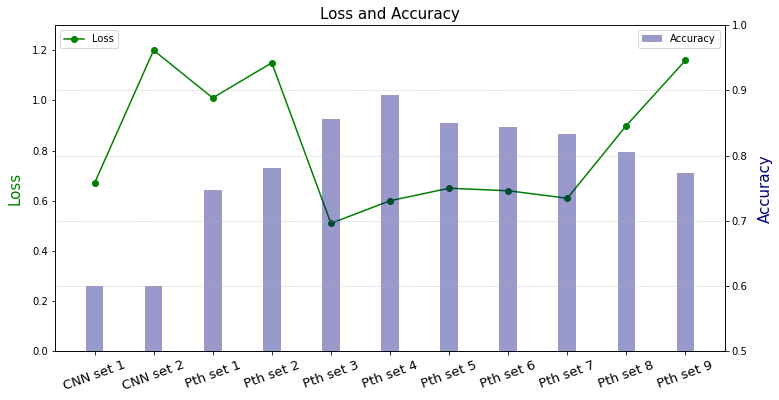

In [ ]:
# loss / acc
plt.figure(figsize=(12,6))

plt.plot( df['loss'], color='green', linewidth=1.5, marker='o', label='Loss')
plt.ylabel('Loss', color='green', labelpad = 10, fontsize=15)
# plt.xlabel('Image Set', fontsize=15)
plt.xticks( rotation = 20, fontsize=13)
plt.ylim(0.0, 1.3)
plt.legend(loc = 'upper left')

ax=plt.gca()
ax2=ax.twinx()

ax2.bar(df.Sets, df['acc'],alpha=0.4 ,width=0.3, color='navy' , label = 'Accuracy' )
ax2.set_ylabel('Accuracy', color='navy' , labelpad = 10 , fontsize=15)
plt.ylim(0.5, 1.0)
plt.legend(loc = 'upper right')

plt.title('Loss and Accuracy', fontsize=15)
plt.grid(True, axis='y', alpha=0.5, linestyle='--')
plt.show()

# 아쉬운 점
- CNN의 신경망을 더 깊게 탐구하지 못한 것이 아쉽다.
- pytorch 전이학습에 여러 알고리즘이 존재하지만 Resnet34만 사용한 것이 아쉽다.
    - 다음 기회에는 다양한 알고리즘도 사용해보자.

# 개선사항
- 웰시코기 종은 애초에 통통한 특징을 갖는다.
- 객체의 윤곽과 배경을 구분하는 코드를 만들어보자